# Programming Assignment \#1
## Eren Akgunduz

In [1]:
import os
import sys
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Logger

The logging system **definitely** came in handy when I was testing my code in the Python script. Although it *does* also work within this notebook, I feel that it's unnecessary and creates clutter for the outputs. In the interest of displaying only the necessary plots and info, I changed the logging level here to warnings only (to keep it quiet).

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

fh = logging.StreamHandler()
fmt = logging.Formatter(
    "%(asctime)s %(levelname)s %(lineno)d:%(filename)s(%(process)d) - %(message)s"
)
fh.setFormatter(fmt)
logger.addHandler(fh)

In [3]:
# grid of tuning parameters represented by lambda
l = np.array([10**-2, 10**-1, 1, 10, 10**2, 10**3, 10**4])

### Functions

In [4]:
def preprocess_data(filename) -> tuple:
    "Take in raw data and convert it to a workable format/state"
    if not isinstance(filename, str):
        raise TypeError("Filename should be a string :)")

    try:
        datafile = f"{os.getcwd()}/{filename}"
        logger.debug(datafile)
        if not os.path.exists(datafile):
            raise OSError("Expected data file, didn't find it :/")

        df = pd.read_csv(datafile, sep=",")  # read and pass to dataframe
        mapping = {
            "Gender": {"Male": 0, "Female": 1},
            "Student": {"No": 0, "Yes": 1},
            "Married": {"No": 0, "Yes": 1},
        }  # so no ambiguity about how we encode categorical columns
        df = df.replace(mapping)

        # convert dataframe to numpy array for faster computations
        return (df.columns.to_numpy(), np.array(df))
    except OSError:
        print("Couldn't load in the data due to OS error.")
        sys.exit("Check if things are right and try again :)")

In [5]:
def ridge_regression(data) -> tuple:
    "Establish design matrix and response vector, prepare both for ridge regression"
    y = data[:, 9]  # extract only the data from the output column (balance)
    y = (lambda c: c - c.mean())(y)  # IIFE to center response vector
    logger.debug(y.shape)
    logger.debug(y.mean())

    dm = np.delete(data, 9, axis=1)  # extract the design matrix
    X = (dm - np.mean(dm, axis=0)) / np.std(dm, axis=0)  # standardize (center & scale)

    logger.debug(X.shape)
    logger.debug(np.mean(X[:, 6]))
    logger.debug(np.std(X[:, 6]))
    return (X, y)

In [6]:
def gradient_descent(X, y, l, a=10**-5) -> np.ndarray:
    "Implementation of vectorized batch gradient descent, applying ridge regression"

    def gd(l):
        # starting parameters vector
        b = np.array([np.random.rand() for _ in range(X.shape[1])])
        for _ in range(10**5):  # total iterations for each tuning parameter
            b = b - 2 * a * (l * b - X.T @ (y - X @ b))
        return b

    coeffs = np.zeros((7, 9))
    logger.debug(coeffs)

    if not isinstance(l, int):
        for index, val in enumerate(l):
            b = gd(val)
            coeffs[index] = b
    else:
        coeffs = gd(l)
    return coeffs

In [7]:
def cross_validation(data, k=5) -> np.ndarray:
    "Implementation of relevant gradient descent utilizing k-fold cross validation"
    if not isinstance(k, int):
        raise TypeError("Number of folds should be an integer :)")

    data_shuffled = data  # make a copy of the original data
    # shuffle the copy so the data in each fold are randomly determined
    # np.random.seed(0)
    np.random.shuffle(data_shuffled)
    logger.debug(f"{data_shuffled.shape}\n{data_shuffled}")

    # create tensor containing each equally shaped fold
    folds = np.array(np.split(data_shuffled, k))  # splits row-wise by default
    logger.debug(f"{folds.shape}\n{folds}")  # confirm that things look right

    cv_errors = []
    for index, fold in enumerate(folds):
        logger.debug(index)
        train = np.delete(folds, index, axis=0)
        train = train.reshape(-1, train.shape[2])
        validation = fold
        # logger.debug(f"{train.shape}\n{validation.shape}")
        # logger.debug(train[:1])
        # logger.debug(validation[:1])
        train_X, train_y = ridge_regression(train)
        val_X, val_y = ridge_regression(validation)
        b = gradient_descent(train_X, train_y, l)
        # after preparing and training data, once again check that things look ok
        logger.debug(f"{l.shape} {b.shape} {val_X.shape} {b[0].shape} {val_y.shape[0]}")
        mse = [
            ((val_y - val_X @ b[i]).T @ (val_y - val_X @ b[i]) / val_y.shape[0])
            for i, _ in enumerate(l)
        ]
        cv_errors.append(mse)

    cv_error = np.array(cv_errors).T
    logger.debug(f"{cv_error.shape} {cv_error}")
    cv_error = np.array([l.mean() for l in cv_error])
    logger.debug(f"{cv_error.shape} {cv_error}")
    return cv_error

In [8]:
columns, data = preprocess_data("Credit_N400_p9.csv")  # unpack the tuple

### Deliverable \#1

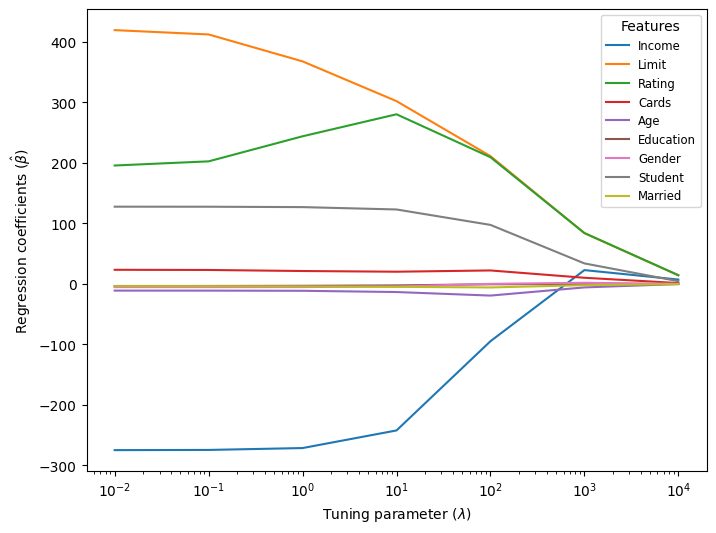

In [9]:
X, y = ridge_regression(data)
# transpose so that each row is one of the nine features with the seven columns for TP
b = gradient_descent(X, y, l).T  # use default value for learning rate
# this way, each index (row) has the vector I need to plot points
plt.figure(figsize=(8, 6))
plt.xscale("log")
[plt.plot(l, b, label=f"{columns[i]}") for i, b in enumerate(b)]
plt.xlabel(r"Tuning parameter ($\lambda$)")
plt.ylabel(r"Regression coefficients ($\hat{\beta}$)")
plt.legend(title="Features", fontsize="small")
plt.show()

### Deliverable \#2

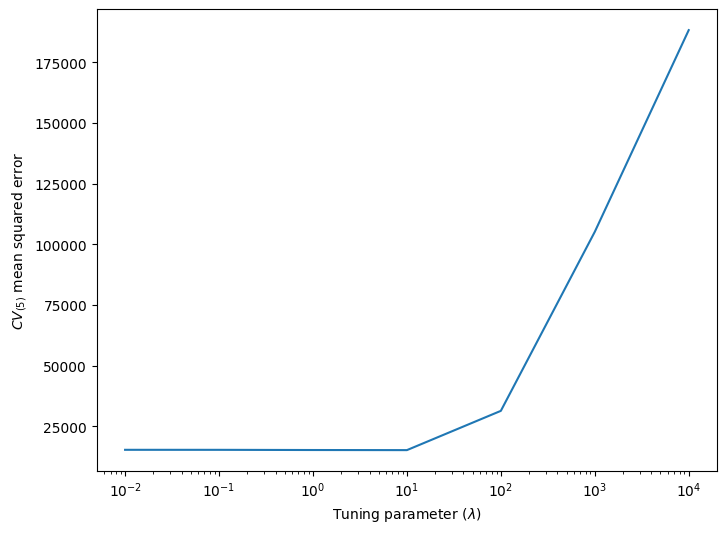

In [10]:
cv_error = cross_validation(data)
plt.figure(figsize=(8, 6))
plt.xscale("log")
plt.plot(l, cv_error)
plt.xlabel(r"Tuning parameter ($\lambda$)")
plt.ylabel(r"$CV_{(5)}$ mean squared error")
plt.show()

### Deliverable \#3

In [11]:
l_optimal = int(l[np.argmin(cv_error)])

In [12]:
l_optimal

10

### Deliverable \#4

In [13]:
b = gradient_descent(X, y, l_optimal)

In [14]:
b

array([-242.10833392,  302.25028739,  280.52528947,   20.27479689,
        -13.32129241,   -2.36122776,   -4.18577233,  123.16827701,
         -4.71110792])